# DGCNN: Triangular mesh dataset

## Pre Processed Point Cloud: 
What it does: 
1. Load and Normalize point cloud
2. Downsample using FPS
3. Save the pre processed data

In [15]:
import os
import glob
import numpy as np
import open3d as o3d
from tqdm import tqdm

# --------------------------------------------------
# Utils
# --------------------------------------------------

def load_ply_numpy(path):
    pcd = o3d.io.read_point_cloud(path)
    pts = np.asarray(pcd.points).astype(np.float32)
    return pts

def normalize_pointcloud(points):
    centroid = points.mean(axis=0)
    points = points - centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    points = points / (scale + 1e-9)
    return points, centroid, scale

def farthest_point_sample_numpy(points, n_samples):
    N = points.shape[0]
    if n_samples >= N:
        return np.arange(N, dtype=np.int64)

    centroids = np.zeros((n_samples,), dtype=np.int64)
    distances = np.ones((N,), dtype=np.float32) * 1e10
    farthest = np.random.randint(0, N)

    for i in range(n_samples):
        centroids[i] = farthest
        centroid = points[farthest]
        dist = np.sum((points - centroid) ** 2, axis=1)
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest = np.argmax(distances)

    return centroids


# --------------------------------------------------
# Main Preprocessing Function
# --------------------------------------------------

def preprocess_pointclouds(
    input_ply_dir,
    output_dir,
    npoints=2048,
    start_idx=0,
    end_idx=None,
    seed=42
):
    """
    Args:
        input_ply_dir (str): folder with 10K-point .ply files
        output_dir (str): folder to save preprocessed .npz files
        npoints (int): number of points after FPS
        start_idx (int): start index for conversion
        end_idx (int or None): end index (exclusive). None = till end
        seed (int): random seed for FPS reproducibility
    """

    np.random.seed(seed)
    os.makedirs(output_dir, exist_ok=True)

    ply_files = sorted(glob.glob(os.path.join(input_ply_dir, "*.ply")))

    if end_idx is None:
        end_idx = len(ply_files)

    ply_files = ply_files[start_idx:end_idx]

    print(f"Preprocessing files [{start_idx}:{end_idx}]")
    print(f"Total files to process: {len(ply_files)}")

    for i, ply_path in enumerate(tqdm(ply_files)):
        fname = os.path.splitext(os.path.basename(ply_path))[0]
        out_path = os.path.join(output_dir, f"{fname}.npz")

        # Skip if already processed
        if os.path.exists(out_path):
            continue

        # Load
        pts = load_ply_numpy(ply_path)

        # Normalize
        pts_norm, centroid, scale = normalize_pointcloud(pts)

        # FPS
        ids = farthest_point_sample_numpy(pts_norm, npoints)
        pts_2048 = pts_norm[ids]

        # Save
        np.savez(
            out_path,
            points=pts_2048.astype(np.float32),
            centroid=centroid.astype(np.float32),
            scale=np.float32(scale)
        )


# --------------------------------------------------
# Example Usage
# --------------------------------------------------
if __name__ == "__main__":

    INPUT_PLY_DIR = "02_dataset/FielGrwon_ZeaMays_RawPCD_10k"
    OUTPUT_DIR = "02_dataset/processed_pc_2048"

    preprocess_pointclouds(
        input_ply_dir=INPUT_PLY_DIR,
        output_dir=OUTPUT_DIR,
        npoints=2048,
        start_idx=501,     # change this to resume
        end_idx=1045,     # or None to process all
        seed=42
    )


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Preprocessing files [501:1045]
Total files to process: 544


100%|██████████| 544/544 [05:38<00:00,  1.61it/s]


## Auto Encoder: DGCNN + MLP 

### Import Libraries

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

### Verify Dataset Directory

In [8]:
DATA_DIR = "02_dataset/processed_pc_2048"

files = sorted([
    f for f in os.listdir(DATA_DIR)
    if f.endswith(".npz")
])

print("Total samples:", len(files))
print("First 5 files:", files[:5])


Total samples: 1045
First 5 files: ['0001.npz', '0002.npz', '0003.npz', '0004.npz', '0005.npz']


### Dataset Class

In [9]:
class PointCloudDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = sorted([
            f for f in os.listdir(data_dir)
            if f.endswith(".npz")
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)

        points = data["points"]  # (2048, 3)

        # Convert to torch
        points = torch.from_numpy(points).float()  # (2048, 3)

        # Transpose to (3, 2048) for DGCNN
        points = points.transpose(0, 1)

        return points


### Verify Data Loader class

In [10]:
dataset = PointCloudDataset(DATA_DIR)

print("Dataset length:", len(dataset))

sample = dataset[0]
print("Sample shape:", sample.shape)
print("Sample dtype:", sample.dtype)


Dataset length: 1045
Sample shape: torch.Size([3, 2048])
Sample dtype: torch.float32


In [11]:
BATCH_SIZE = 8
NUM_WORKERS = 4  # set to 0 if on Windows or debugging

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)


In [12]:
for batch_idx, points in enumerate(dataloader):
    print("Batch index:", batch_idx)
    print("Batch shape:", points.shape)
    break


Batch index: 0
Batch shape: torch.Size([8, 3, 2048])


## Model Architecture

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### KNN and Graph Feature Utils

In [14]:
def knn(x, k):
    # x: (B, C, N)
    inner = -2 * torch.matmul(x.transpose(2, 1), x)  # (B, N, N)
    xx = torch.sum(x ** 2, dim=1, keepdim=True)       # (B, 1, N)
    pairwise_distance = xx.transpose(2, 1) + inner + xx

    idx = pairwise_distance.topk(k=k, dim=-1, largest=False)[1]
    return idx  # (B, N, k)

def get_graph_feature(x, k=10):
    # x: (B, C, N)
    B, C, N = x.size()
    idx = knn(x, k=k)  # (B, N, k)

    device = x.device
    idx_base = torch.arange(0, B, device=device).view(-1, 1, 1) * N
    idx = idx + idx_base
    idx = idx.view(-1)

    x = x.transpose(2, 1).contiguous()  # (B, N, C)
    neighbors = x.view(B * N, C)[idx]
    neighbors = neighbors.view(B, N, k, C).permute(0, 3, 1, 2)

    x = x.permute(0, 2, 1).unsqueeze(-1).repeat(1, 1, 1, k)
    edge_feature = torch.cat((x, neighbors - x), dim=1)

    return edge_feature  # (B, 2C, N, k)


### EdgeConv(Regularization):

In [15]:
class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # x: (B, 2C, N, k)
        x = self.conv(x)
        x = x.max(dim=-1)[0]  # (B, out_channels, N)
        return x

### Encoder

In [16]:
class DGCNN_Encoder(nn.Module):
    def __init__(self, k=20, latent_dim=128):
        super().__init__()
        self.k = k

        self.ec1 = EdgeConv(6, 64, dropout=0.1)
        self.ec2 = EdgeConv(128, 64, dropout=0.1)
        self.ec3 = EdgeConv(128, 128, dropout=0.1)
        self.ec4 = EdgeConv(256, 256, dropout=0.1)

        self.fc = nn.Sequential(
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        # x: (B, 3, N)
        x1 = self.ec1(get_graph_feature(x, self.k))    # (B, 64, N)
        x2 = self.ec2(get_graph_feature(x1, self.k))   # (B, 64, N)
        x3 = self.ec3(get_graph_feature(x2, self.k))   # (B, 128, N)
        x4 = self.ec4(get_graph_feature(x3, self.k))   # (B, 256, N)

        x_cat = torch.cat((x1, x2, x3, x4), dim=1)     # (B, 512, N)
        x_global = F.adaptive_max_pool1d(x_cat, 1).squeeze(-1)

        z = self.fc(x_global)                          # (B, 128)
        return z


### Decoder

In [17]:
class MLP_Decoder(nn.Module):
    def __init__(self, latent_dim=128, num_points=2048):
        super().__init__()
        self.num_points = num_points

        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 1024),
            nn.ReLU(),

            nn.Linear(1024, num_points * 3)
        )

    def forward(self, z):
        x = self.mlp(z)
        x = x.view(-1, self.num_points, 3)
        return x


### Full AutoEncoder Wrapper

In [18]:
class DGCNN_AutoEncoder(nn.Module):
    def __init__(self, k=20, latent_dim=128, num_points=2048):
        super().__init__()
        self.encoder = DGCNN_Encoder(k, latent_dim)
        self.decoder = MLP_Decoder(latent_dim, num_points)

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z


### Chamfer Distance

In [19]:
def chamfer_distance(pcd1, pcd2):
    # pcd1, pcd2: (B, N, 3)
    diff = torch.cdist(pcd1, pcd2)
    loss1 = diff.min(dim=2)[0].mean()
    loss2 = diff.min(dim=1)[0].mean()
    return loss1 + loss2


### Forward Pass Sanity Check

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DGCNN_AutoEncoder().to(device)
model.eval()

dummy_input = torch.randn(4, 3, 2048).to(device)

with torch.no_grad():
    recon, z = model(dummy_input)

print("Latent shape:", z.shape)
print("Reconstruction shape:", recon.shape)


Latent shape: torch.Size([4, 128])
Reconstruction shape: torch.Size([4, 2048, 3])


## Training Setup

### Config

In [49]:
class Config:
    # ------------------------
    # Dataset
    # ------------------------
    DATA_DIR = "02_dataset/processed_pc_2048"

    # ------------------------
    # Model
    # ------------------------
    NUM_POINTS = 2048
    LATENT_DIM = 128
    K = 10

    # ------------------------
    # Training
    # ------------------------
    BATCH_SIZE = 8
    EPOCHS = 50000 # 400
    LR = 1e-3  # till 400 epoch 1e-3
    WEIGHT_DECAY = 1e-5 # till 400 epoch 1e-4

    # ------------------------
    # System
    # ------------------------
    DEVICE = "cuda"
    NUM_WORKERS = 4

    # ------------------------
    # Paths
    # ------------------------
    EXP_NAME = "dgcnn_ae_maize"

    CHECKPOINT_DIR = f"checkpoints/{EXP_NAME}"
    MODEL_DIR = f"models/{EXP_NAME}"
    LOG_DIR = f"logs/{EXP_NAME}"

    CHECKPOINT_NAME = "latest_checkpoint.pth"
    FINAL_MODEL_NAME = "dgcnn_ae_final.pth"
    LOG_FILE = "training.log"

In [50]:
import os

def make_dirs(cfg):
    os.makedirs(cfg.CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(cfg.MODEL_DIR, exist_ok=True)
    os.makedirs(cfg.LOG_DIR, exist_ok=True)

make_dirs(Config)


In [51]:
def log_message(log_path, message):
    with open(log_path, "a") as f:
        f.write(message + "\n")
    print(message)


In [52]:
from torch.utils.data import DataLoader

dataset = PointCloudDataset(Config.DATA_DIR)

dataloader = DataLoader(
    dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=Config.NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)


### Model, Optimizer, Loss

In [34]:
import torch

device = torch.device(Config.DEVICE if torch.cuda.is_available() else "cpu")

model = DGCNN_AutoEncoder(
    k=Config.K,
    latent_dim=Config.LATENT_DIM,
    num_points=Config.NUM_POINTS
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=Config.LR,
    weight_decay=Config.WEIGHT_DECAY
)


### Checkpoint Load

In [53]:
start_epoch = 1
checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, Config.CHECKPOINT_NAME)
log_path = os.path.join(Config.LOG_DIR, Config.LOG_FILE)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"] + 1

    log_message(
        log_path,
        f"[RESUME] Loaded checkpoint from epoch {checkpoint['epoch']}"
    )
else:
    log_message(log_path, "[START] Training from scratch")


[RESUME] Loaded checkpoint from epoch 7000


## Training Loop

In [ ]:
from tqdm import tqdm
import time

model.train()

for epoch in range(start_epoch, Config.EPOCHS + 1):
    epoch_loss = 0.0
    start_time = time.time()

    # Wrap dataloader with tqdm
    for points in tqdm(dataloader, desc=f"Epoch {epoch}/{Config.EPOCHS}", ncols=100):
        points = points.to(device)               # (B, 3, 2048)

        optimizer.zero_grad()

        recon, _ = model(points)                 # (B, 2048, 3)
        loss = chamfer_distance(
            points.transpose(1, 2), recon
        )

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    epoch_time = time.time() - start_time

    log_message(
        log_path,
        f"Epoch [{epoch:03d}/{Config.EPOCHS}] | "
        f"Loss: {epoch_loss:.6f} | "
        f"Time: {epoch_time:.2f}s"
    )

    # ------------------------
    # Save checkpoint every 10 epochs
    # ------------------------
    if epoch % 500 == 0:
        torch.save(
            {
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            },
            checkpoint_path
        )


Epoch 7001/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 33.83it/s]


Epoch [7001/50000] | Loss: 0.050062 | Time: 3.85s


Epoch 7002/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 33.43it/s]


Epoch [7002/50000] | Loss: 0.049895 | Time: 3.89s


Epoch 7003/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 32.87it/s]


Epoch [7003/50000] | Loss: 0.049729 | Time: 3.96s


Epoch 7004/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 33.52it/s]


Epoch [7004/50000] | Loss: 0.049839 | Time: 3.88s


Epoch 7005/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 33.08it/s]


Epoch [7005/50000] | Loss: 0.050171 | Time: 3.93s


Epoch 7006/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 32.99it/s]


Epoch [7006/50000] | Loss: 0.049419 | Time: 3.94s


Epoch 7007/50000: 100%|███████████████████████████████████████████| 130/130 [00:03<00:00, 32.92it/s]


Epoch [7007/50000] | Loss: 0.050106 | Time: 3.95s


Epoch 7008/50000:   4%|█▋                                           | 5/130 [00:00<00:08, 14.27it/s]

### Save model

In [37]:
import os
import torch

# 1. Prepare a dictionary of config values
config_to_save = {
    "EPOCHS": Config.EPOCHS,
    "BATCH_SIZE": Config.BATCH_SIZE,
    "LATENT_DIM": Config.LATENT_DIM,
    "MODEL_DIR": Config.MODEL_DIR,
    "FINAL_MODEL_NAME": Config.FINAL_MODEL_NAME,
    "K": Config.K,            # EdgeConv k
    "NUM_POINTS": Config.NUM_POINTS
}

# 2. Path to save the final model
final_model_path = os.path.join(Config.MODEL_DIR, Config.FINAL_MODEL_NAME)

# 3. Save model state + config
torch.save(
    {
        "model_state": model.state_dict(),
        "config": config_to_save
    },
    final_model_path
)

# 4. Log message
log_message(
    log_path,
    f"[DONE] Final model saved to {final_model_path}"
)


[DONE] Final model saved to models/dgcnn_ae_maize/dgcnn_ae_final.pth


## Inference

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model architecture (same as during training)
model = DGCNN_AutoEncoder(
    k=10,
    latent_dim=128,
    num_points=2048
).to(device)

# Load checkpoint
checkpoint = torch.load(final_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
model.eval()  # Important for inference

# Config is safe to use as a dict
config = checkpoint["config"]


In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the same architecture
model = DGCNN_AutoEncoder(
    k=10,
    latent_dim=128,
    num_points=2048
).to(device)

# Load saved weights (final model or checkpoint)
checkpoint_path = "models/dgcnn_ae_maize_k_20/dgcnn_ae_final.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])


<All keys matched successfully>

In [40]:
model.eval()  # Important for dropout & batchnorm

DGCNN_AutoEncoder(
  (encoder): DGCNN_Encoder(
    (ec1): EdgeConv(
      (conv): Sequential(
        (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (ec2): EdgeConv(
      (conv): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (ec3): EdgeConv(
      (conv): Sequential(
        (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (

In [45]:
import numpy as np

# Load a preprocessed point cloud
data = np.load("02_dataset/processed_pc_2048/0002.npz")
points = data["points"]  # (2048, 3)

# Convert to torch and add batch dimension
points = torch.from_numpy(points).float().unsqueeze(0)  # (1, 2048, 3)
points = points.transpose(1, 2).to(device)              # (1, 3, 2048)


In [46]:
with torch.no_grad():
    recon, latent = model(points)

print("Latent vector shape:", latent.shape)       # (1, 128)
print("Reconstructed points shape:", recon.shape) # (1, 2048, 3)


Latent vector shape: torch.Size([1, 128])
Reconstructed points shape: torch.Size([1, 2048, 3])


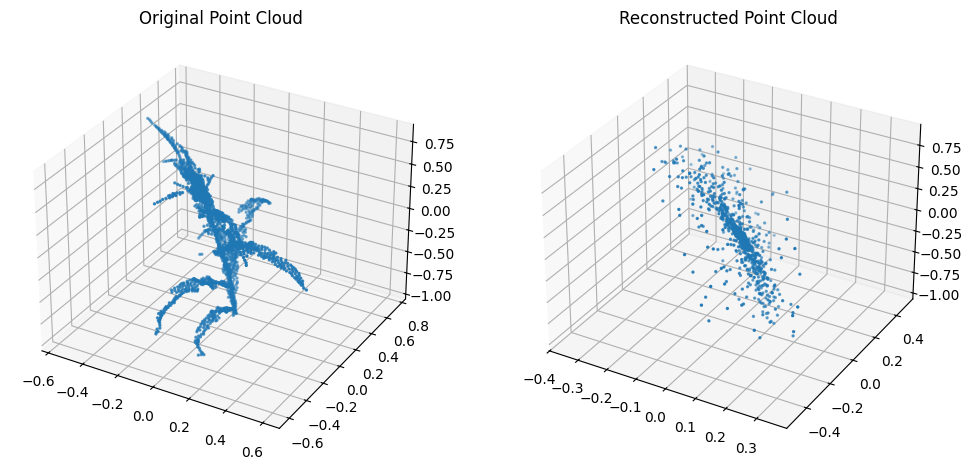

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points_np = points.squeeze(0).cpu().numpy().T   # (2048, 3)
recon_np = recon.squeeze(0).cpu().numpy()      # (2048, 3)

fig = plt.figure(figsize=(12,6))

# Original
ax = fig.add_subplot(121, projection='3d')
ax.scatter(points_np[:,0], points_np[:,1], points_np[:,2], s=2)
ax.set_title("Original Point Cloud")

# Reconstruction
ax = fig.add_subplot(122, projection='3d')
ax.scatter(recon_np[:,0], recon_np[:,1], recon_np[:,2], s=2)
ax.set_title("Reconstructed Point Cloud")

plt.show()

In [48]:
import open3d as o3d
import numpy as np

def save_ply_open3d(points, filename):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    o3d.io.write_point_cloud(filename, pcd)

# Convert tensors
# points_np = points.squeeze(0).cpu().numpy().T
recon_np = recon.squeeze(0).cpu().numpy()

# save_ply_open3d(points_np, "original.ply")
save_ply_open3d(recon_np, "recons_dgcnn_ae_maize_7000_0002.ply")


In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from mpl_toolkits.mplot3d import Axes3D


In [57]:
all_latents = []

model.eval()

with torch.no_grad():
    for batch in dataloader:
        # batch is already a tensor: (B, 2048, 3)
        points = batch.to(device)

        _, z = model(points)          # z: (B, latent_dim)

        all_latents.append(z.cpu().numpy())

latents = np.concatenate(all_latents, axis=0)

print("Latent vectors shape:", latents.shape)


Latent vectors shape: (496, 128)


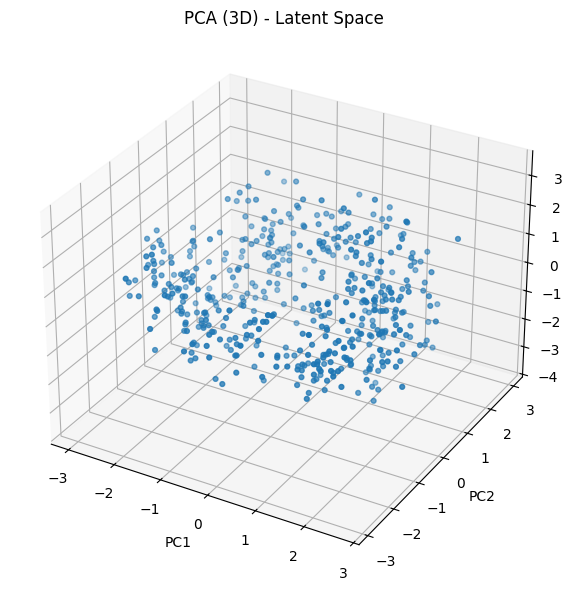

In [58]:
pca_3d = PCA(n_components=3)
latents_pca_3d = pca_3d.fit_transform(latents)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    latents_pca_3d[:, 0],
    latents_pca_3d[:, 1],
    latents_pca_3d[:, 2],
    s=12
)

ax.set_title("PCA (3D) - Latent Space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.tight_layout()
plt.show()


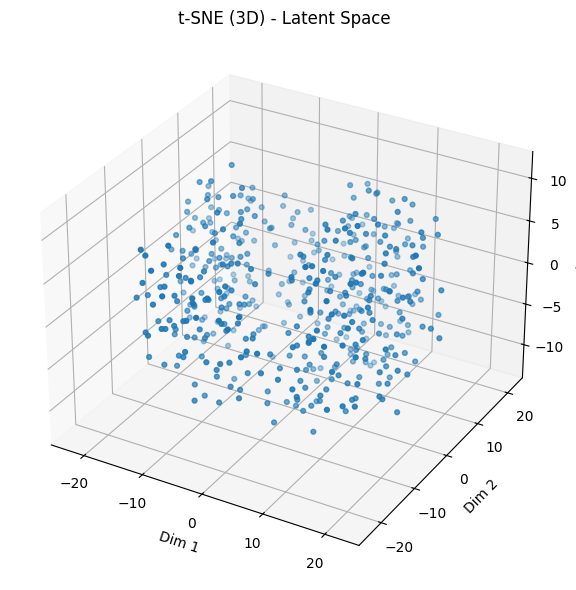

In [59]:
latents_pca_50 = PCA(
    n_components=min(50, latents.shape[1])
).fit_transform(latents)

tsne_3d = TSNE(
    n_components=3,
    perplexity=30,
    init="pca",
    learning_rate="auto",
    random_state=42
)

latents_tsne_3d = tsne_3d.fit_transform(latents_pca_50)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    latents_tsne_3d[:, 0],
    latents_tsne_3d[:, 1],
    latents_tsne_3d[:, 2],
    s=12
)

ax.set_title("t-SNE (3D) - Latent Space")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")

plt.tight_layout()
plt.show()


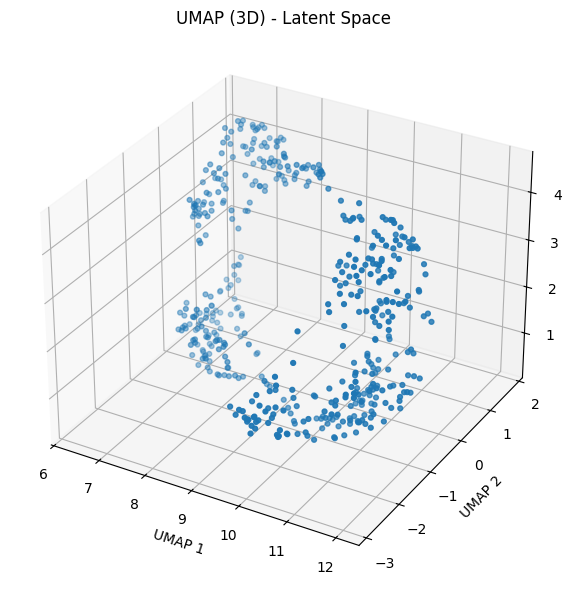

In [60]:
umap_3d = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=3,
    random_state=None,
    n_jobs=4
)

latents_umap_3d = umap_3d.fit_transform(latents)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    latents_umap_3d[:, 0],
    latents_umap_3d[:, 1],
    latents_umap_3d[:, 2],
    s=12
)

ax.set_title("UMAP (3D) - Latent Space")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

plt.tight_layout()
plt.show()
